In [1]:
import matplotlib.pyplot as plt
import numpy as np
import shapely as sl

from spideymaps import Spideymap

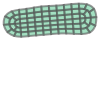

In [2]:
label_file = r"T:\MIGRATED\Lab_Members\Daniel_Foust\Data\RNA-DNA Hybrids\FCL136 fenA-PAmCherry del(polA)\2023-08-05_fcl136_20ms\2023-08-05_fcl136_20ms_001_seg.npy"
labels = np.load(label_file, allow_pickle=True).item()['masks']
mask = labels == 2

map = Spideymap(bimage=mask)
map.make_grid(radius=10, n_shells=3, n_cols=8, n_phi=(2,4,6))
sl.GeometryCollection(list(map.polygons.values()))

In [4]:
map.count(0)

In [10]:
isinstance('polygons', Spideymap)

False

In [12]:
[*3* [map.phi_list[-1]]]

[array([0.        , 0.9424778 , 3.14159265]),
 array([0.        , 0.9424778 , 3.14159265]),
 array([0.        , 0.9424778 , 3.14159265])]

### build rings

CPU times: total: 0 ns
Wall time: 12.2 ms


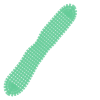

In [767]:
%%time
radius = 12
rdglen = map.rdg.length
n_cols = 30

dists = np.linspace(radius, rdglen - radius, n_cols + 1)

rdgpts = sl.line_interpolate_point(
            map.rdg, 
            dists
            )

rdgsegs = {i+1:
           sl.ops.substring(map.rdg, start_dist=d0, end_dist=d1) 
           for i, (d0, d1) 
           in enumerate(zip(dists[:-1], dists[1:]))}

rdgpts_l = sl.line_interpolate_point(
            map.rdg, 
            (dists - 0.5).clip(0)
            )

rdgpts_r = sl.line_interpolate_point(
            map.rdg, 
            (dists + 0.5).clip(rdglen)
            )

rads_north = [] # polar region north end of ridgeline
rads_south = [] # polar region south end of ridgeline
rads_top = [] # above ridgeline
rads_bottom = [] # below ridgeline

for theta in np.linspace(-np.pi/2, np.pi/2, 12):
    rads_north.append(build_rad(rdgpts_l[0], rdgpts_r[0], map.bnd, origin=rdgpts[0], theta=theta+np.pi))
    rads_south.append(build_rad(rdgpts_l[-1], rdgpts_r[-1], map.bnd, origin=rdgpts[-1], theta=theta))

for i in range(1, len(rdgpts)-1):
    rads_top.append(
        build_rad(rdgpts_l[i], rdgpts_r[i], map.bnd, origin=rdgpts[i], theta=np.pi/2)
    )
    rads_bottom.append(
        build_rad(rdgpts_l[i], rdgpts_r[i], map.bnd, origin=rdgpts[i], theta=-np.pi/2)
    )

rads_sorted = np.array([*rads_north[::-1],
                        *rads_top,
                        *rads_south[::-1],
                        *rads_bottom[::-1]])

n_rings = 4

ring_fracs = np.linspace(0, 1, n_rings+1)[1:-1]

rings = []

for ring_frac in ring_fracs:
    ring = sl.LinearRing(
        (v.line_interpolate_point(ring_frac, normalized=True) for v in rads_sorted)
    )
    rings.append(ring)

sl.GeometryCollection((map.rdg, *rads_sorted, *rings))


CPU times: total: 0 ns
Wall time: 22.7 ms


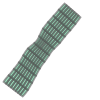

In [783]:
%%time
radius = 12
rdglen = map.rdg.length
n_cols = 12

dists = np.linspace(radius, rdglen - radius, n_cols + 1)

rdgpts = sl.line_interpolate_point(
            map.rdg, 
            dists
            )

rdgsegs = {i+1:
           sl.ops.substring(map.rdg, start_dist=d0, end_dist=d1) 
           for i, (d0, d1) 
           in enumerate(zip(dists[:-1], dists[1:]))}

rdgpts_l = sl.line_interpolate_point(
            map.rdg, 
            (dists - 0.5).clip(0)
            )

rdgpts_r = sl.line_interpolate_point(
            map.rdg, 
            (dists + 0.5).clip(rdglen)
            )

polygons = {}
arcs = []

# innermost shell
for i_l, rdgseg in rdgsegs.items():
    rad0 = build_rad(rdgpts_l[i_l-1], rdgpts_r[i_l-1], bnd=map.bnd, origin=rdgpts[i_l-1])
    rad1 = build_rad(rdgpts_l[i_l], rdgpts_r[i_l], bnd=map.bnd, origin=rdgpts[i_l])

    arc0 = rdgseg

    for i_r, ring in enumerate(rings):
        pt0 = sl.intersection(rad0, ring)
        pt1 = sl.intersection(rad1, ring)
        arc1 = get_arc(pt0, pt1, ring)

        polygons[i_r,i_l,1] = sl.Polygon(
            (*arc0.coords, 
            *arc1.coords[::-1],)
            )
        arc0 = arc1

    i_r += 1
    arc1 = get_arc(sl.Point(rad0.coords[-1]), sl.Point(rad1.coords[-1]), map.bnd)
    polygons[i_r,i_l,1] = sl.Polygon(
            (*arc0.coords, 
            *arc1.coords[::-1],)
            )

    ###
    rad0 = build_rad(rdgpts_l[i_l-1], rdgpts_r[i_l-1], bnd=map.bnd, origin=rdgpts[i_l-1], theta=-np.pi/2)
    rad1 = build_rad(rdgpts_l[i_l], rdgpts_r[i_l], bnd=map.bnd, origin=rdgpts[i_l], theta=-np.pi/2)

    arc0 = rdgseg

    for i_r, ring in enumerate(rings):
        pt0 = sl.intersection(rad0, ring)
        pt1 = sl.intersection(rad1, ring)
        arc1 = get_arc(pt0, pt1, ring)

        polygons[i_r,i_l,-1] = sl.Polygon(
            (*arc0.coords, 
            *arc1.coords[::-1],)
            )
        arc0 = arc1

    i_r += 1
    arc1 = get_arc(sl.Point(rad0.coords[-1]), sl.Point(rad1.coords[-1]), map.bnd)
    polygons[i_r,i_l,-1] = sl.Polygon(
            (*arc0.coords, 
            *arc1.coords[::-1],)
            )

    
    
    # rad0 = build_rad(rdgpts_l[i_l-1], rdgpts_r[i_l-1], bnd=rings[0], origin=rdgpts[i_l-1], theta=-np.pi/2)
    # rad1 = build_rad(rdgpts_l[i_l], rdgpts_r[i_l], bnd=rings[0], origin=rdgpts[i_l], theta=-np.pi/2)

    # arc = get_arc(sl.Point(rad0.coords[-1]), sl.Point(rad1.coords[-1]), rings[0])

    # polygons[0,i_l,-1] = sl.Polygon(
    #     (*rdgseg.coords, 
    #     *rad1.coords,
    #     *arc.coords[::-1],
    #     *rad0.coords[::-1])
    #     )

sl.GeometryCollection((*list(polygons.values()),))

In [6]:
np.linspace(0,1,2)

array([0., 1.])

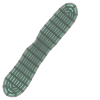

In [787]:
phi_list = [np.array([0, np.pi]),
       np.linspace(0, np.pi, 3),
       np.linspace(0, np.pi, 4),
       np.linspace(0, np.pi, 5)]

phi = phi_list[0]

## first pole
# innermost ring
rad0 = build_rad(rdgpts_l[0], rdgpts_r[0], bnd=rings[0], origin=rdgpts[0], theta=np.pi/2+phi[0])
for i, p in enumerate(phi[1:]):
    rad1 = build_rad(rdgpts_l[0], rdgpts_r[0], bnd=rings[0], origin=rdgpts[0], theta=np.pi/2 + p)
    arc = get_arc(sl.Point(rad0.coords[-1]), sl.Point(rad1.coords[-1]), bnd=rings[0])
    polygons[0,0,p] = sl.Polygon((*rdgpts[0].coords, *arc.coords))
    rad0 = rad1

# remaining rings
all_rings = [*rings, map.bnd]
for i_r, phi in enumerate(phi_list[1:]):
    rad0 = build_rad(rdgpts_l[0], rdgpts_r[0], bnd=all_rings[i_r+1], origin=rdgpts[0], theta=np.pi/2+phi[0])
    for i, p in enumerate(phi[1:]):
        rad1 = build_rad(rdgpts_l[0], rdgpts_r[0], bnd=all_rings[i_r+1], origin=rdgpts[0], theta=np.pi/2 + p)
        pt0 = sl.intersection(rad0, all_rings[i_r])
        pt1 = sl.intersection(rad1, all_rings[i_r])
        arc0 = get_arc(pt0, pt1, bnd=all_rings[i_r])
        arc1 = get_arc(sl.Point(rad0.coords[-1]), sl.Point(rad1.coords[-1]), bnd=all_rings[i_r+1])

        rad0 = rad1

        polygons[i_r+1,0,p] = sl.Polygon((*arc0.coords, *arc1.coords[::-1]))

## second pole
phi = phi_list[0]
rad0 = build_rad(rdgpts_l[-1], rdgpts_r[-1], bnd=all_rings[0], origin=rdgpts[-1], theta=np.pi/2 - phi[0])
for i, p in enumerate(phi[1:]):
    rad1 = build_rad(rdgpts_l[-1], rdgpts_r[-1], bnd=all_rings[0], origin=rdgpts[-1], theta=np.pi/2 - p)
    arc = get_arc(sl.Point(rad0.coords[-1]), sl.Point(rad1.coords[-1]), bnd=all_rings[0])
    polygons[0,-1,p] = sl.Polygon((*rdgpts[-1].coords, *arc.coords))
    rad0 = rad1

# remaining rings
for i_r, phi in enumerate(phi_list[1:]):
    rad0 = build_rad(rdgpts_l[-1], rdgpts_r[-1], bnd=all_rings[i_r+1], origin=rdgpts[-1], theta=np.pi/2 - phi[0])
    for i, p in enumerate(phi[1:]):
        rad1 = build_rad(rdgpts_l[-1], rdgpts_r[-1], bnd=all_rings[i_r+1], origin=rdgpts[-1], theta=np.pi/2 - p)
        pt0 = sl.intersection(rad0, all_rings[i_r])
        pt1 = sl.intersection(rad1, all_rings[i_r])
        arc0 = get_arc(pt0, pt1, bnd=all_rings[i_r])
        arc1 = get_arc(sl.Point(rad0.coords[-1]), sl.Point(rad1.coords[-1]), bnd=all_rings[i_r+1])

        rad0 = rad1

        polygons[i_r+1,-1,p] = sl.Polygon((*arc0.coords, *arc1.coords[::-1]))


sl.GeometryCollection((*list(polygons.values()),))

In [788]:
polygons.keys()

dict_keys([(0, 1, 1), (1, 1, 1), (2, 1, 1), (3, 1, 1), (0, 1, -1), (1, 1, -1), (2, 1, -1), (3, 1, -1), (0, 2, 1), (1, 2, 1), (2, 2, 1), (3, 2, 1), (0, 2, -1), (1, 2, -1), (2, 2, -1), (3, 2, -1), (0, 3, 1), (1, 3, 1), (2, 3, 1), (3, 3, 1), (0, 3, -1), (1, 3, -1), (2, 3, -1), (3, 3, -1), (0, 4, 1), (1, 4, 1), (2, 4, 1), (3, 4, 1), (0, 4, -1), (1, 4, -1), (2, 4, -1), (3, 4, -1), (0, 5, 1), (1, 5, 1), (2, 5, 1), (3, 5, 1), (0, 5, -1), (1, 5, -1), (2, 5, -1), (3, 5, -1), (0, 6, 1), (1, 6, 1), (2, 6, 1), (3, 6, 1), (0, 6, -1), (1, 6, -1), (2, 6, -1), (3, 6, -1), (0, 7, 1), (1, 7, 1), (2, 7, 1), (3, 7, 1), (0, 7, -1), (1, 7, -1), (2, 7, -1), (3, 7, -1), (0, 8, 1), (1, 8, 1), (2, 8, 1), (3, 8, 1), (0, 8, -1), (1, 8, -1), (2, 8, -1), (3, 8, -1), (0, 9, 1), (1, 9, 1), (2, 9, 1), (3, 9, 1), (0, 9, -1), (1, 9, -1), (2, 9, -1), (3, 9, -1), (0, 10, 1), (1, 10, 1), (2, 10, 1), (3, 10, 1), (0, 10, -1), (1, 10, -1), (2, 10, -1), (3, 10, -1), (0, 11, 1), (1, 11, 1), (2, 11, 1), (3, 11, 1), (0, 11, -1), 

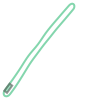

In [619]:
sl.GeometryCollection((rings[0], *list(polygons.values())))

In [530]:
radius = 10
rdglen = map.rdg.length
n_cols = 100

dists = np.linspace(radius, rdglen - radius, n_cols + 1)

rdgpts = sl.line_interpolate_point(
            map.rdg, 
            dists
            )

rdgsegs = {i+1:
           sl.ops.substring(map.rdg, start_dist=d0, end_dist=d1) 
           for i, (d0, d1) 
           in enumerate(zip(dists[:-1], dists[1:]))}

rdgpts_l = sl.line_interpolate_point(
            map.rdg, 
            (dists - 0.5).clip(0)
            )

rdgpts_r = sl.line_interpolate_point(
            map.rdg, 
            (dists + 0.5).clip(rdglen)
            )

rads_north = [] # polar region north end of ridgeline
rads_south = [] # polar region south end of ridgeline
rads_top = [] # above ridgeline
rads_bottom = [] # below ridgeline

for theta in np.linspace(-np.pi/2, np.pi/2, 8):
    rads_north.append(build_rad(map.rdgpts[0], map.rdgpts[1], map.bnd, theta=theta+np.pi))
    rads_south.append(build_rad(map.rdgpts[-2], map.rdgpts[-1], map.bnd, origin=map.rdgpts[-1], theta=theta))

for i in range(1, len(map.rdgpts)-1):
    rads_top.append(
        build_rad(map.rdgpts[i-1], map.rdgpts[i+1], map.bnd, origin=map.rdgpts[i], theta=np.pi/2)
    )
    rads_bottom.append(
        build_rad(map.rdgpts[i-1], map.rdgpts[i+1], map.bnd, origin=map.rdgpts[i], theta=-np.pi/2)
    )

# sl.GeometryCollection((map.bnd, *rads_north, *rads_south, *rads_top, *rads_bottom))

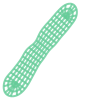

In [531]:
rads_sorted = np.array([*verts_north[::-1], *verts_top, *verts_south[::-1], *verts_bottom[::-1]])

n_rings = 3

ring_fracs = np.linspace(0, 1, n_rings+1)[1:-1]

rings = []

for ring_frac in ring_fracs:
    ring = sl.LinearRing(
        (v.line_interpolate_point(ring_frac, normalized=True) for v in verts_sorted)
    )
    rings.append(ring)

sl.GeometryCollection((map.rdg, map.bnd, *rads_sorted, *rings))


In [382]:
mainrdg = sl.LineString(map.rdg.coords[1:-1])

In [394]:
radius = 10
rdglen = sl.length(map.rdg)
n_cols = 10
dist = np.linspace(radius, rdglen - radius, n_cols + 1)

rdgsegs = {i+1:
           sl.ops.substring(map.rdg, start_dist=d0, end_dist=d1) 
           for i, (d0, d1) 
           in enumerate(zip(dist[:-1], dist[1:]))}

In [398]:
for i in rdgsegs:
    rdgseg = rdgsegs[i]
    # pt0 = sl.Point(rdgseg.coords[0])
    # pt1 = sl.Point(rdgseg.coords[-1])
    # rad0 = build_rad(pt0, pt1, map.bnd)
    # rad1 = build_rad(pt0, pt1, map.bnd)

    rad0 = rads_north[i-1]

    rad0seg = sl.ops.substring(rad0, start_dist=0, end_dist=0.5)
    rad1seg = sl.ops.substring(rad1, start_dist=0.5, end_dist=0)

    polygon = sl.polygonize((rdgseg, rad0seg, rad1seg))

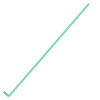

In [401]:
sl.GeometryCollection((rdgseg, rad0seg, rad1seg))

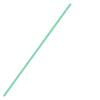

In [380]:
radius = 10
sl.ops.substring(map.rdg, radius, radius+2)

In [376]:
sl.ops.substring?

Signature: sl.ops.substring(geom, start_dist, end_dist, normalized=False)
Docstring:
Return a line segment between specified distances along a LineString

Negative distance values are taken as measured in the reverse
direction from the end of the geometry. Out-of-range index
values are handled by clamping them to the valid range of values.

If the start distance equals the end distance, a Point is returned.

If the start distance is actually beyond the end distance, then the
reversed substring is returned such that the start distance is
at the first coordinate.

Parameters
----------
geom : LineString
    The geometry to get a substring of.
start_dist : float
    The distance along `geom` of the start of the substring.
end_dist : float
    The distance along `geom` of the end of the substring.
normalized : bool, False
    Whether the distance parameters are interpreted as a
    fraction of the geometry's length.

Returns
-------
Union[Point, LineString]
    The substring between `start